In [1]:
%load_ext autoreload
%autoreload 2

In [19]:
import os
import sys

# Add the parent directory to the Python path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))

import dataloader
import modules 
import plots
from trainer import Trainer
import torch 
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

## Load in the data

See `dataloader.py` for implementation details.

In [5]:
diabetes_dataset = dataloader.DiabetesDataset(batch_size=8)

[autoreload of dataloader failed: Traceback (most recent call last):
  File "/Users/patrickrowe/miniconda3/envs/main/lib/python3.12/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/Users/patrickrowe/miniconda3/envs/main/lib/python3.12/site-packages/IPython/extensions/autoreload.py", line 500, in superreload
    update_generic(old_obj, new_obj)
  File "/Users/patrickrowe/miniconda3/envs/main/lib/python3.12/site-packages/IPython/extensions/autoreload.py", line 397, in update_generic
    update(a, b)
  File "/Users/patrickrowe/miniconda3/envs/main/lib/python3.12/site-packages/IPython/extensions/autoreload.py", line 365, in update_class
    update_instances(old, new)
  File "/Users/patrickrowe/miniconda3/envs/main/lib/python3.12/site-packages/IPython/extensions/autoreload.py", line 323, in update_instances
    object.__setattr__(ref, "__class__", new)
TypeError: __class__ assignment: 'DiabetesDataset' object layout di

In [6]:
test_batch = next(iter(diabetes_dataset.get_dataloader(train=True)))
print(test_batch[0].shape)
print(test_batch[1].shape)

torch.Size([8, 10])
torch.Size([8, 1])


## Initialise a model

In this implementation, we can specify limited variations on our existing model architecture by passing in a list of integers specifying the shapes of the hidden layers we desire. These will be linear fully connected layers with ReLU activation and a single output node. For example:

```
network_architecture = [50, 50]
model = modules.LinearReLUMLP(network_architecture)

print(model.net)

>>>

ModuleList(
  (0): LazyLinear(in_features=0, out_features=50, bias=True)
  (1): ReLU()
  (2): LazyLinear(in_features=0, out_features=50, bias=True)
  (3): ReLU()
  (4): LazyLinear(in_features=0, out_features=1, bias=True)
)
```

In [15]:
#  a
network_architecture = [16, 4]
model = modules.LinearReLUMLP(network_architecture, learning_rate=0.015)
model.apply_initialization(torch.randn(1, len(diabetes_dataset.feature_names)))

/Users/patrickrowe/miniconda3/envs/main/lib/python3.12/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [16]:
print(model.net)

Sequential(
  (0): Linear(in_features=10, out_features=16, bias=True)
  (1): ReLU()
  (2): Linear(in_features=16, out_features=4, bias=True)
  (3): ReLU()
  (4): Linear(in_features=4, out_features=1, bias=True)
)


## Initialise a trainer

The trainer combines our data and model and facilitates the actual training loop.

In [17]:
trainer = Trainer(max_epochs=100)
trainer.fit(model, diabetes_dataset)

Model running on cpu

 EPOCH 

Epoch 1/100, Training Loss: 28134.0620
Epoch 1/100, Validation Loss: 2306.3667

 EPOCH 

Epoch 2/100, Training Loss: 18381.6767
Epoch 2/100, Validation Loss: 379.3790

 EPOCH 

Epoch 3/100, Training Loss: 5199.7718
Epoch 3/100, Validation Loss: 4537.7212

 EPOCH 

Epoch 4/100, Training Loss: 3962.1779
Epoch 4/100, Validation Loss: 2246.8115

 EPOCH 

Epoch 5/100, Training Loss: 3679.3552
Epoch 5/100, Validation Loss: 1836.3682

 EPOCH 

Epoch 6/100, Training Loss: 3601.1066
Epoch 6/100, Validation Loss: 925.3754

 EPOCH 

Epoch 7/100, Training Loss: 3398.6228
Epoch 7/100, Validation Loss: 866.8719

 EPOCH 

Epoch 8/100, Training Loss: 3296.5025
Epoch 8/100, Validation Loss: 397.0027

 EPOCH 

Epoch 9/100, Training Loss: 3252.1947
Epoch 9/100, Validation Loss: 165.0756

 EPOCH 

Epoch 10/100, Training Loss: 3128.2917
Epoch 10/100, Validation Loss: 91.2422

 EPOCH 

Epoch 11/100, Training Loss: 3061.6645
Epoch 11/100, Validation Loss: 19.4842

 EPOCH 

Epoc

tensor(77.1078)
0.5145114660263062


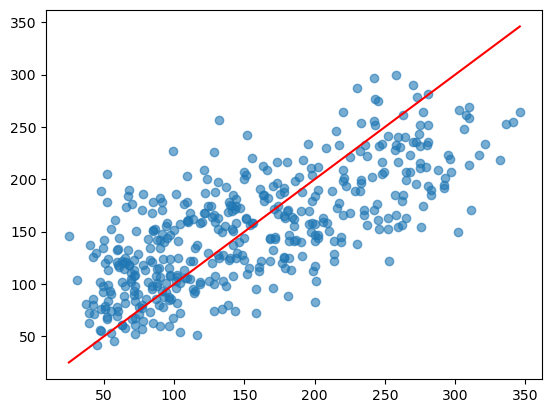

In [20]:

y = torch.tensor(diabetes_dataset.labels.astype(float), dtype=torch.float32)
y_hat = model(torch.tensor(diabetes_dataset.features.astype(float), dtype=torch.float32))

# mae 
mae = torch.mean(torch.abs(y - y_hat))
print(mae.detach())

# r-squared
r2 = r2_score(y.detach().numpy(), y_hat.detach().numpy())
print(r2)

fig, ax = plt.subplots(ncols=1, nrows=1)

ax.scatter(y.detach().numpy(), y_hat.detach().numpy(), alpha=0.6, label='Predicted')

# add a line
ax.plot([min(y), max(y)], [min(y), max(y)], color='red', label='Real')